# 0-Setting

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow.keras.utils import plot_model

# 공통 모듈 임포트
import numpy as np
import os
import copy
import pandas as pd

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from tensorflow.keras import models, layers, optimizers, losses, metrics, activations

----
# 1. fMNIST 데이터 불러오기

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

----
# 2. 모델 Development

## 17.3.1 적층 오토인코더 (stacked autoencoder)

In [3]:
def build_stacked_ae():
    stacked_encoder = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(100, activation="selu"),
        layers.Dense(10, activation="selu"),
    ])
    stacked_decoder = models.Sequential([
        layers.Dense(100, activation="selu", input_shape=[10]),
        layers.Dense(28 * 28, activation="sigmoid"),
        layers.Reshape([28, 28])
    ])
    stacked_ae = models.Sequential([stacked_encoder, stacked_decoder])
    
    
    return stacked_ae, stacked_encoder


In [4]:
[model_ae, model_encoder] = build_stacked_ae()

In [5]:
model_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                79510     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            80284     
Total params: 159,794
Trainable params: 159,794
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [7]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
model, encoder = build_stacked_ae()
# model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('m_stacked_ae.h5', 
                                                         save_best_only=True)
              
history = model.fit(x_train, x_train, epochs=5,
                    validation_split=0.2,
                    callbacks=[model_checkpoint_cb])
# model과 encoder가 동시에 학습되고 있음. 

Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3510 - rounded_accuracy: 0.8746 - val_loss: 0.3224 - val_rounded_accuracy: 0.8986
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3166 - rounded_accuracy: 0.9049 - val_loss: 0.3151 - val_rounded_accuracy: 0.9087
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3114 - rounded_accuracy: 0.9090 - val_loss: 0.3102 - val_rounded_accuracy: 0.9124
Epoch 4/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3077 - rounded_accuracy: 0.9123 - val_loss: 0.3065 - val_rounded_accuracy: 0.9145
Epoch 5/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3049 - rounded_accuracy: 0.9145 - val_loss: 0.3040 - val_rounded_accuracy: 0.9166


## 17.3.5. 가중치 묶기

In [17]:

class DenseTranspose(layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                     initializer="zeros",
                                     shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

def build_tied_ae():
    dense_1 = layers.Dense(100, activation="selu")
    dense_2 = layers.Dense(30, activation="selu")
    
    tied_encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        dense_1,
        dense_2
    ])
    
    tied_decoder = models.Sequential([
        DenseTranspose(dense_2, activation = "selu"),
        DenseTranspose(dense_1, activation = "sigmoid"),
        layers.Reshape([28, 28])
    ])
    
    tied_ae = models.Sequential([tied_encoder, tied_decoder])
    
    return tied_ae, tied_encoder 

In [15]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
model, encoder = build_tied_ae()
model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])
# model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('m_tied_ae.h5', 
#                                                          save_best_only=True)
# model = tf.keras.models.load_model('m_tied_ae.h5')
history = model.fit(x_train, x_train, epochs=5,
                    validation_split=0.2)
#                    callbacks=[model_checkpoint_cb])
# model과 encoder가 동시에 학습되고 있음. 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_16 (Sequential)   (None, 28, 28)            82414     
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3296 - rounded_accuracy: 0.8932 - val_loss: 0.3052 - val_rounded_accuracy: 0.9135
Epoch 2/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2989 - rounded_accuracy: 0.9211 - val_loss: 0.2953 - val_rounded_accuracy: 0.9248
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2927 - rounded_accuracy: 0.9270 - val_loss: 0.2914 - val_rounded_accuracy: 0.9310
Epoch 4/5
1500/1500 [============

## 17.4 합성곱 오토인코더

In [42]:
def build_conv_ae():
    conv_encoder = models.Sequential([
        layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        layers.MaxPool2D(pool_size=2)
    ])
    
    conv_decoder = models.Sequential([
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                               activation="selu", input_shape=[3,3,64]),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                               activation="selu"),
        layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                               activation="sigmoid"),
        layers.Reshape([28, 28])
    ])
    
    conv_ae = models.Sequential([conv_encoder, conv_decoder])   
    
    return conv_ae, conv_encoder


In [43]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [44]:
model, encoder = build_conv_ae()
model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])
# model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('m_tied_ae.h5', 
#                                                          save_best_only=True)
# model = tf.keras.models.load_model('m_tied_ae.h5')
history = model.fit(x_train, x_train, epochs=5,
                    validation_split=0.2)
# model과 encoder가 동시에 학습되고 있음. 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_27 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_28 (Sequential)   (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.2903 - val_rounded_accuracy: 0.9230
Epoch 2/5
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2752 - rounded_accuracy: 0.9420 - val_loss: 0.2749 - val_rounded_accuracy: 0.9432
Epoch 3/5
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2703 - rounded_accuracy: 0.9469 - val_loss: 0.2695 - val_rounded_accuracy: 0.9476
Epoch 4/5
1500/1500 [=======

In [45]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

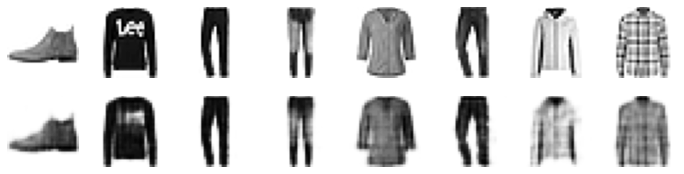

In [46]:
#dropout = layers.Dropout(0.5)
#noise = layers.GaussianNoise(0.2)

show_reconstructions(model, x_test)

## 17.5 순환 오토인코더

In [47]:
def build_recurrent_ae():

    recurrent_encoder = models.Sequential([
        layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
        layers.LSTM(30)
    ])
    
    recurrent_decoder = models.Sequential([
        layers.RepeatVector(28, input_shape=[30]),
        layers.LSTM(100, return_sequences=True),
        layers.TimeDistributed(layers.Dense(28, activation="sigmoid"))
    ])
    
    recurrent_ae = models.Sequential([recurrent_encoder, recurrent_decoder])
    
    return recurrent_ae, recurrent_encoder


In [48]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [49]:
model, encoder = build_recurrent_ae()
model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])
# model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('m_tied_ae.h5', 
#                                                          save_best_only=True)
# model = tf.keras.models.load_model('m_tied_ae.h5')
history = model.fit(x_train, x_train, epochs=5,
                    validation_split=0.2)
# model과 encoder가 동시에 학습되고 있음. 

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 30)                67320     
_________________________________________________________________
sequential_31 (Sequential)   (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 100s 67ms/step - loss: 0.3816 - rounded_accuracy: 0.8539 - val_loss: 0.3315 - val_rounded_accuracy: 0.8965
Epoch 2/5
1500/1500 [==============================] - 101s 67ms/step - loss: 0.3249 - rounded_accuracy: 0.8968 - val_loss: 0.3141 - val_rounded_accuracy: 0.9073
Epoch 3/5
1500/1500 [==============================] - 99s 66ms/step - loss: 0.3133 - rounded_accuracy: 0.9064 - val_loss: 0.3088 - val_rounded_accuracy: 0.9087
Epoch 4/5
1500/1500 [===

## 17.6 잡음제거 오토인코더

In [62]:

def build_denoising_ae():
    denoising_encoder = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.GaussianNoise(0.2),
        layers.Dense(100, activation="selu"),
        layers.Dense(30, activation="selu")
    ])
    
    denoising_decoder = models.Sequential([
        layers.Dense(100, activation ="selu", input_shape=[30]),
        layers.Dense(28*28, activation = "sigmoid"),
        layers.Reshape([28,28])        
    ])
    
    denoising_ae = models.Sequential([denoising_encoder, denoising_decoder])

    return denoising_ae


def build_dropout_ae():
    
    dropout_encoder = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dropout(0.5),
        layers.Dense(100, activation="selu"),
        layers.Dense(30, activation="selu")
    ])
    
    dropout_decoder = models.Sequential([
        layers.Dense(100, activation ="selu", input_shape=[30]),
        layers.Dense(28*28, activation = "sigmoid"),
        layers.Reshape([28,28])    
    ])

    dropout_ae = models.Sequential([dropout_encoder, dropout_decoder])

    return dropout_ae

In [58]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [61]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [63]:
# noise_factor = 0.5
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
# x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# x_test_noisy = np.clip(x_test_noisy, 0., 1.)    

model1= build_denoising_ae()
model1.summary()
model1.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])

history = model1.fit(x_train, x_train, epochs=5,
                    validation_split=0.2) 

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_42 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_43 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3439 - rounded_accuracy: 0.8823 - val_loss: 0.3187 - val_rounded_accuracy: 0.8993
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3101 - rounded_accuracy: 0.9111 - val_loss: 0.3089 - val_rounded_accuracy: 0.9161
Epoch 3/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3039 - rounded_accuracy: 0.9165 - val_loss: 0.3006 - val_rounded_accuracy: 0.9195
Epoch 4/5
1500/1500 [===========

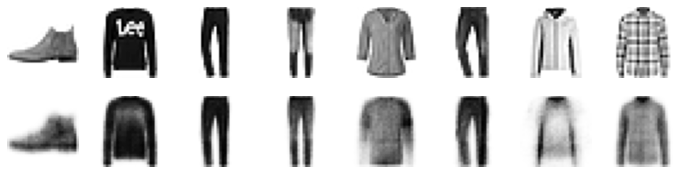

In [64]:
show_reconstructions(model1, x_test)

In [65]:
model2 = build_dropout_ae()
model2.summary()
model2.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])

history = model2.fit(x_train, x_train, epochs=5,
                    validation_split=0.2)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_45 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_46 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3495 - rounded_accuracy: 0.8761 - val_loss: 0.3164 - val_rounded_accuracy: 0.9049
Epoch 2/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3153 - rounded_accuracy: 0.9052 - val_loss: 0.3072 - val_rounded_accuracy: 0.9136
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3093 - rounded_accuracy: 0.9101 - val_loss: 0.3027 - val_rounded_accuracy: 0.9184
Epoch 4/5
1500/1500 [===========

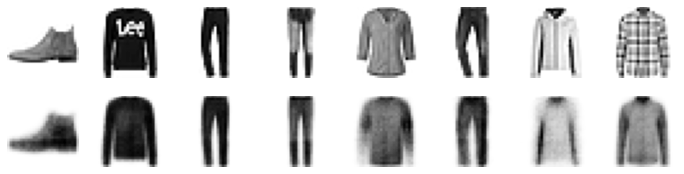

In [66]:
show_reconstructions(model2, x_test)

## 17.7 희소 오토인코더

In [67]:
def build_sparse_ae():
    
    sparse_l1_encoder = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(100, activation="selu"),
        layers.Dense(300, activation="sigmoid"),
        layers.ActivityRegularization(l1=1e-3)
    ])

    sparse_l1_decoder = models.Sequential([
        layers.Dense(100, activation="selu", input_shape=[300]),
        layers.Dense(28 * 28, activation="sigmoid"),
        layers.Reshape([28, 28])
    ])

    sparse_l1_ae = models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
    
    return sparse_l1_ae

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [68]:
model = build_sparse_ae()
model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1.5), 
              metrics=[rounded_accuracy])

history = model.fit(x_train, x_train, epochs=5,
                    validation_split=0.2)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_48 (Sequential)   (None, 300)               108800    
_________________________________________________________________
sequential_49 (Sequential)   (None, 28, 28)            109284    
Total params: 218,084
Trainable params: 218,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4183 - rounded_accuracy: 0.8273 - val_loss: 0.3786 - val_rounded_accuracy: 0.8662
Epoch 2/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3631 - rounded_accuracy: 0.8736 - val_loss: 0.3559 - val_rounded_accuracy: 0.8822
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3464 - rounded_accuracy: 0.8855 - val_loss: 0.3425 - val_rounded_accuracy: 0.8891
Epoch 4/5
1500/1500 [===========

In [69]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

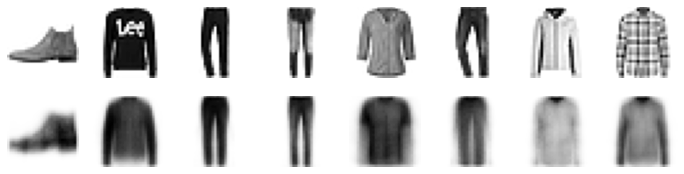

In [70]:
show_reconstructions(model, x_test)

----
# 3. 모델 컴파일 & 훈련

In [4]:
# def rounded_accuracy(y_true, y_pred):
#     return metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
# model, encoder = build_stacked_ae()
# model.summary()
# model.compile(loss="binary_crossentropy",
#                 optimizer=optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
# history = model.fit(x_train, x_train, epochs=5,
#                       validation_split=0.2)
# # model과 encoder가 동시에 학습되고 있음. 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                79510     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            80284     
Total params: 159,794
Trainable params: 159,794
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3500 - rounded_accuracy: 0.8757 - val_loss: 0.3199 - val_rounded_accuracy: 0.9038
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3155 - rounded_accuracy: 0.9057 - val_loss: 0.3126 - val_rounded_accuracy: 0.9083
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3102 - rounded_accuracy: 0.9101 - val_loss: 0.3098 - val_rounded_accuracy: 0.9115
Epoch 4/20
1500/1500 [=======

----
# 4. 모델 시각화

## 17.3.2 재구성 시각화

In [25]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        


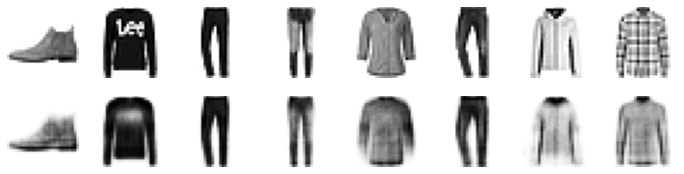

In [26]:
#dropout = layers.Dropout(0.5)
#noise = layers.GaussianNoise(0.2)

show_reconstructions(model, x_test)

## 17.3.3 패션 MNIST 데이터셋 시각화

In [71]:
from sklearn.manifold import TSNE

# input에 encoder, -> 10차원으로 축소하고, 이것을 TSNE로 2차원화, plot
def tsne_projection(encoder, x_data):
    x_data_compressed = encoder.predict(x_data)
    tsne = TSNE()
    out_tsne = tsne.fit_transform(x_data_compressed)
    
    return out_tsne

def plot_projection(out_tsne, label):
    x_2d = (out_tsne - out_tsne.min()) / (out_tsne.max() - out_tsne.min())
    plt.figure(figsize=(6,6))
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=label, s=10, cmap="tab10")
    plt.axis("off")
    plt.show()

def plot_fmnist(out_tsne, x_data, y_data):
    x_2d = (out_tsne - out_tsne.min()) / (out_tsne.max() - out_tsne.min())
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_data, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(x_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x_data[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_data[index]), "lw": 2})
            plt.gca().add_artist(imagebox)
    plt.axis("off")
    plt.show()
    

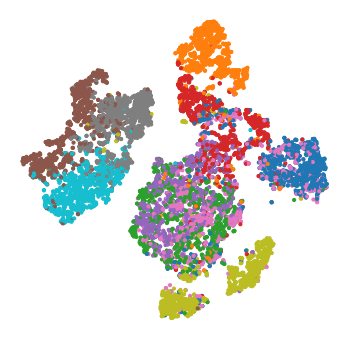

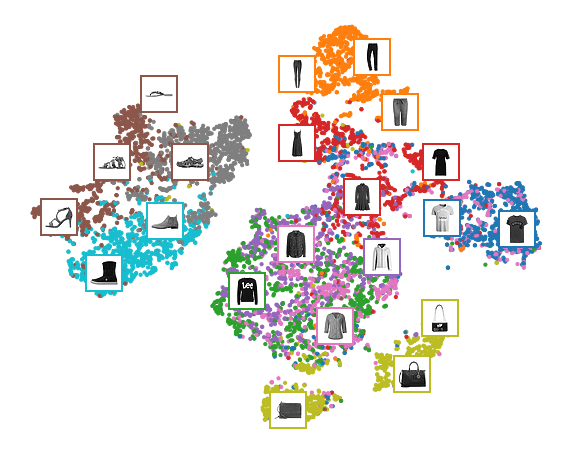

In [72]:
out_tsne = tsne_projection(encoder, x_test)
plot_projection(out_tsne, y_test)
plot_fmnist(out_tsne, x_test, y_test)

----
# 5. 뉴런 활성화 시각화

In [73]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    
    
def plot_activations_histogram(encoder, x_data, height=1, n_bins=10):
    x_codings = encoder(x_data).numpy()
    activation_means = x_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    
    plot_percent_hist(ax1, x_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

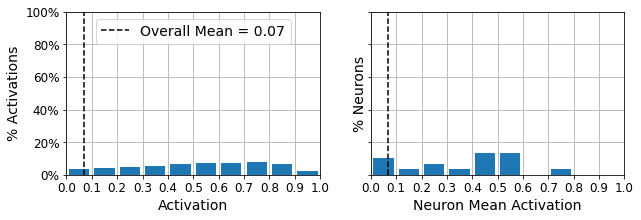

In [74]:
plot_activations_histogram(encoder, x_test, )
plt.show()